In [32]:
import librosa
import numpy as np
from typing import Tuple
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import tempfile
import os
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)

2.16.1


In [27]:
def combine_tracks(path_1:str, path_2:str, mult_1=1, mult_2=1, sr=22050) -> Tuple[np.array, int]:
    y_1, sr_1 = librosa.load(path_1, sr=sr)
    y_2, sr_2 = librosa.load(path_2, sr=sr)
    if(y_1.size > y_2.size):
        y_1 = np.pad(y_1, (0,sr_1 - (y_1.size%sr_1)), 'constant', constant_values= (0))
        y_2 = np.pad(y_2, (0,y_1.size-y_2.size), 'constant', constant_values= (0))
    else:
        y_2 = np.pad(y_2, (0,sr_2 - (y_2.size%sr_2)), 'constant', constant_values= (0))
        y_1 = np.pad(y_1, (0,y_2.size-y_1.size), 'constant', constant_values= (0))
    y = np.add(y_1 * mult_1, y_2 * mult_2)
    
    return (y, sr)

def get_mel_spectograms(y:np.array, sr:int) -> np.array:
    return librosa.amplitude_to_db(
        librosa.feature.melspectrogram(
            y = y.reshape((int) (y.size/sr), sr), 
            hop_length= 256, 
            n_mels = 96
            )
        )
    

In [28]:
y, sr = combine_tracks("sample_audio_training/trumpet/0005.wav", "sample_audio_training/violin/0010.wav")
out = get_mel_spectograms(y, sr)
out.shape


(5, 96, 87)

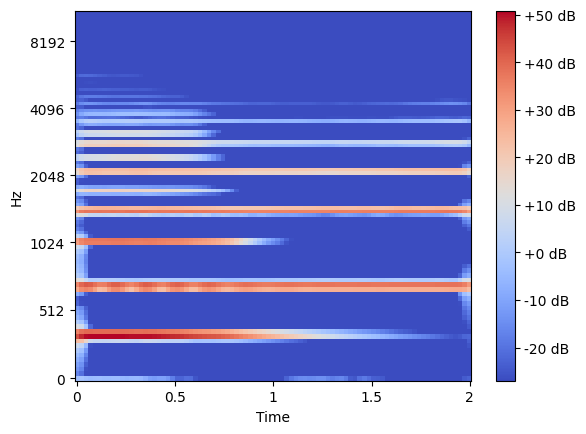

In [33]:
librosa.display.specshow(out[2], sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

Model Time :)

In [35]:
tf.random.set_seed(22)